
# Convolutional Neural Networks and Transfer Learning
&emsp;&emsp;By Daniel Silva

By the end of todays lesson you will:
-  Know which kinds of problems can be solved using CNNs
-  Understand what a CNN learns and how it learns
-  Have an intution behind how a CNN extracts features from data, and uses these features to generate predictions
-  Be able to utilize transfer learning to achieve state of the art accuracy on novel datasets

## Set up 

Importing some of the libraries we'll be using, as well as PyTorch.

In [0]:
# standard imports (Numpy, Pandas, Matplotlib)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
from PIL import ImageFile
# import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

# PyTorch imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
from torch.utils.data import DataLoader
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision import transforms

# Extras
import time
import os

The script below downloads the dataset for today's lesson

!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null

In [0]:
#cur_dir = os.getcwd()
#good_folders = ['dogImages.zip', 'dogImages', 'CNN lecture.ipynb', '.ipynb_checkpoints']
#for folder in os.listdir('/home/danielzgsilva/notebooks/AI@UCF_CNNlecture'):
#    if folder not in good_folders:
#        dir_to_move = os.path.join(cur_dir, folder)
#        shutil.move(dir_to_move, os.path.join(data_root, 'test'))

In [0]:
#i = 1
#for folder in os.listdir(data_root):
#    for breed in os.listdir(data_root + folder + '/'):
#oo        shutil.move(data_root + folder + '/' + breed, data_root + folder + '/' + folder.split('.')[1])

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
random.seed(42)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root = '/content/gdrive/My Drive/ucfai/core/fa19/05-cnns/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## What is a Convolutional Neural Network?

CNNs, like the basic neural networks we've been working with, are simply comprised of sequences of linear layers, followed by nonlinearities. There will still be an Input Layer and Output Layer, with intermediate layers known as Hidden Layers. So what makes a CNN any different? <br>

In short, the goal of any CNN is to extract **features** from its input, and use these features to predict the class of its input, based on what the model has learnt about a dataset.

 <img src = "https://drive.google.com/uc?id=1Sw2o_Lo7jWCs2Ek2qdPfuVB1PqkVgd7l">

#### What kinds of problems can be solved using CNNs?

Due to the nature of CNNs they can, and have been, applied to virtually any kind of data that could have features extracted from it <br>Some applications of CNNs include:
-  Audio processing or classification 
-  Natural Lanuage Processing: feature extraction from text
-  Image Classification and Object Detection
    
For today's lesson we will be looking at CNN's most popular application, Computer Vision. This field deals with how computers can be made to gain understanding from images or videos.

Recent advances in Computer Vision have made tasks such as Image Classification and Object Recognition more accessible and accurate than ever before. 

<img src="https://drive.google.com/uc?id=16V6BTGA0zMny3QRNYym2rIc9W5o52CwT">

#### So how are features extracted from data? 

In a typical ANN the linear layers of the model are essentially just matrix multiplications of the entire input matrix by weight matrices.

With CNNs, however, the weights of the model now consist of **filters**, or **kernels**, and the linear layers are known as **Convolutional Layers**. Think of a filter as an (n*n) matrix which just consists of very specific numbers. 

In a Convolutional Layer, these filters are **convoluted** across the input, performing a computatation known as a **Convolution** against the input data. Performing these convolutions against the input data, with very specific filters, is what allows the CNN to extract features from its input.

So basically, the training of a CNN simply involves finding of the best values for each of these filters so that when an input image is passed through the model's layers, specific features are extracted and certain neurons of the last layer are activated so as to predict the correct class.

## Understanding Convolutions


In order to understand the math behind these convolutions we'll visit Victor Powell's page on Setosa.io, which does an excellent job of visualizing the process of convolution.

[Convolution Visualization](http://setosa.io/ev/image-kernels/)
<br> &emsp;&emsp;By Victor Powell

<img src = "https://drive.google.com/uc?id=1aCqVTSeizgP32uoeUQrgMDG6LyQjA2I2">

In short, the above process of taking each (n x n) area in an image, performing an element wise multiplication against a kernel, and adding each of the resulting numbers together to create one output is called a **convolution**

However, in our dog breeds dataset, images are now colored, rather than white and black, meaning each pixel is on an RGB scale. We now say that the image has 3 channels, one for red, green, and blue. Each input image is now comprised of 3 matrices, each representing a color. In PyTorch speak, the input is now a rank 3 tensor (height x width x 3).

<img src = "https://drive.google.com/uc?id=1JQeOW8fR59chlryITJp8UMqztcj7FED_">


Now that our input is 3 channels deep, we don't want to use the same filter for each of the red, green, and blue channels. Imagine, for example, that we are trying to recognize frogs from images. We'd want to activate the green channel much more than blue or red... Makes sense right? Therefore, for RGB images, the initial filters are also 3 channels deep (height x width x 3), to match the input.

<img src = "https://drive.google.com/uc?id=1Nlunme-oWCidedcAUyqJfO50m9xUVIz4">

Even with 3 channels, the concept of sliding and multipling this filter across the input stays the same. However, rather than a single convolution being an element-wise multiplication of 9 things, it's now an element-wise multiplication of 27 things (3 x 3 x 3). Each of these 27 results are still added up into a single number.

<img src = "https://drive.google.com/uc?id=1-z6ng3-crDxSPXX5WeXGWukDnHmI2FMp">

After performing these convolutions across the entire 3 channel input, we're left with an output of only one 1 channel. This is a rank 2 tensor, or 2-d matrix, of what we call **activations**. As we saw earlier, the filter may have activated all of the top edges in the image, for example.

### Layer 1
<img src = "https://drive.google.com/uc?id=19gYZxzqGYykY6rV5yCXWc9Mg-D8ZyNL1">

To extract additional features from the image, we simply apply more filters to the image, each with the goal of **activating** a different feature. Every applied filter results in another 2-d activation matrix, and we stack these along the 3rd dimension to create a multi channel output (16 channels in this case), or rank 3 tensor. 

Each channel in the output now represents a different feature from the image. Each pixel in one channel might represent much left edge was present in a group of pixels, while another channel might represent how much blue to green gradient was present in each group of pixels.

However, thus far all we have is this rank 3 tensor with channels representing simple things such as where the lines or gradients are in the image... So how can our model begin to learn and activate more complex features?

### Layer 2
<img src = "https://drive.google.com/uc?id=1bGHEVIl2y1sDa6PdrRRdaqo6QU9tkgUf">

At this point we feed this 3 dimensional output of the first layer into the next convolutional layer. Again we choose the number of filters to apply, or essentially the number of features we want extracted, and that creates another rank 3 tensor (again height by width by whatever we chose).

The only difference now is that these kernels can't only have 3 channels anymore can they? Their number of channels need to match the output of the previous layer. 

What this does is allow this set of kernels to perform convolutions on all of the previously activated features, simultaneously.. In doing so, the model is able to activate more and more complex features as the image is passed into deeper layers.

To provide some intuition, let's say the first layer uses 2 filters to extract top and right edges, and stacks these activation matrices into a 2 channel output. The next layer could then apply a 2 channel kernel to this output, correct? So, because layer 2's kernel looks at these channels together, one representing top edges and one representing right edges, we could train this kernel to activate only **top right edges** from the 2 channel input.

## Visualizing the Filters and Features

Let's take a look at what exactly these filters are learning. These visualizations come from an awesome paper written by Matt Zeiler, which is all about visualizing the layers of a Convolutional Neural Network. The specific CNN that the paper illustrates is ResNet34, a popular model for Computer Vision which achieves groundbreaking accuracy on the ImageNet dataset. 

ImageNet is a standard in community for benchmarking networks. It contains millions of images of several thousand different classes, things such as cats, cars, and strawberries. The model actually has 34 layers, and ResNet50 has 50 layers, but let's just start with layer 1. There's a few dozen filters in the first layer so we'll just look at a random 9.

<img src = "https://drive.google.com/uc?id=13vCidyvn5hJVlC2I0pC_NZNUSqaI6EFM">

Remember that these kernels operate on groups of pixels adjacent to each other. So it looks like a few of these try to find groups of pixels that form a diagonal line, while others would find gradients that go from yellow to blue, and so forth. They are simple filters that find lines or gradients, etc.

<img src = "https://drive.google.com/uc?id=1F1saYAtvtAehbEZVZvdf8AIYRH1i7p-a">

Layer 2 then takes the results of those filters and perform convolutions on all these simple features stacked together. The left side of the above image are the filters themselves, and the right side shows images that strongly activated these filters. As you can see, the model has now learned slightly more complex filters. There are some that look for top left corners, or right-hand curves,  circles, etc. So, while in layer 1 we had things that could extract just single lines, for example, layer 2's filters can now find bits of images that have two lines joined up or one line repeated, etc.

<img src = "https://drive.google.com/uc?id=13h3lOQAn6DhwWqlakD-W1QvWRZneB4RD">

At this point the model seems to be able to find two dimensional objects, bits of text, geometric patterns, etc. Overall these filters seem to extract repeating patterns, which put together begin to resemble every day objects/images. So again, layer 3 was able to take all the stuff from layer 2 and combine them together to find even richer features.

<img src = "https://drive.google.com/uc?id=13SXsVOk6Ih9VrBh9kOG125h1Eqrgm6yc">

By layer 4 we've got filters that can find generic dog faces, or bird legs, bodies of water, and other bits of objects.
And by layer 5, we've got something that can find the eyeballs of bird and lizards, or faces of particular breeds of dogs, and so forth. So now you see, with this approach of stacking increasingly complex features, how with only a few layers the model can extract these rich features from am image.

In practice this is how it kind of works. The earlier layers learn to activate very simple shapes or gradients, and feed these to following layers to extract richer and richer features. And by the time the input has reached the deepest layers, the model has extracted all the key features needed to classify a 3 channel matrix of pixels into a real world object.

#### Summary of Convolutional Layers

In summary, most **image** models start with a **3 channel input** (height x width x 3), which is passed through a chosen number of **convolutional kernels** (or filters). This gives us an output of height by width by how ever many kernels we chose, where each channel (or depth dimension) represents an activated feature. This process makes up the bulk of one **convolutional layer**

The output of this layer then becomes the input for the next convolutional layer, and the same process is applied. Remember, now the number of channels in each kernel needs to match the number of channels outputted from the previous layer. This allows each set of kernels to examine all of the features extracted thus far, combined. This process of having filters look at all of the previously extracted features at once allows the model to extract increasingly richer features from the input as the image is passed through the model's layers.

## Additional Details Regarding Convolutions

#### Stride

Stride represents the number of pixels the kernels skip over after each convolution is performed. See the visualizations below for a demonstration. A larger stride helps to reduce the spatial dimensions of the layer's output and reduce the computation required, while a smaller stride captures the finer details and relationships between nearby pixels in an input.
 
##### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Stride = 1
<img src="https://drive.google.com/uc?id=11yIZzO8IjEhx7QyVAD2n8ykGmV_DGrfS"> 
##### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Stride = 2
<img src="https://drive.google.com/uc?id=1tVHxKi3XvxaGZKh804-4LVgrvX2OCHgQ"> 

#### Padding

Sometimes, the convolutional filter we choose does not fit perfectly into the input matrix after 'sliding' it across the input. This requires us to pad the input with additional rows or columns. **Padding** can be accomplished using a few different techniques:

*   Zero Padding - pads the input with zeros
*   Valid Padding - drops the part of the input where the filter did not fit.
*   Reflective Padding - pads outer edges with their reflections



We'll illustate both the padding and stride parameters in further detail in the following section.

## End to End Convolutional Neural Networks

Now that we have a base understanding of how a CNN's convolutional layers function to extract features, we can go over a few other common layers that make up a typical CNN. By the end of this section, you'll have an idea of what an end to end CNN architecture is comprised of and the purpose behind each component. We'll take a deeper look at each of these in a second when we build a full fledged CNN in Excel, so don't get discouraged if something doesn't make sense at first.

#### Rectified Linear Unit (ReLU)

Remember, a convolution, at heart, is nothing more than a linear mapping.  So, like in other Neural Networks we've studied, every Convolutional Layer (the linear layer) must be followed by a nonlinearity. This is what allows our model to approximate relationships behind data, as described in the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem). 

The most common nonlinearity, or **Activation Function**, used in CNN architectures is what's known as a **Rectified Linear Unit**, frequently referred to as a **ReLU**. This sounds fancy, but really a ReLU is  simply the function **output =  Max(0, input)**. In other words, applying a ReLU simply involves replacing every negative value in a Conv Layer's output with a 0. In practice, a ReLU will follow after every convolutional layer in a CNN.

### Regularization Techniques

#### Pooling Layers

Another staple in nearly every CNN architecture are a few **Pooling** layers. Pooling uses a technique known as **Down Sampling**, to reduce the number of parameters in your model, while allowing it to better generalize images across different orientations and scales. This is also known as avoiding **overfitting**. In order to do this a pooling layer uses a sliding technique, similar to our conv. layers, but now applying a statistical function over the contents of its window. The pooling windows are also non-overlapping, allowing this technique to greatly reduce the size of its input and, naturally, decrease the number of parameters in the model.

There are many kinds of pooling layers, each with their own advantages and use cases:

-  Max Pooling
-  Average Pooling
-  Global Poolings
-  Etc.

The diagram below shows an example of max pooling. We'll speak further on Global Pooling, later in today's meeting.

 <img src = "https://drive.google.com/uc?id=1cH0LHtXDd4FJnT3qZQSdNxai7MIc2ra0">


#### Dropout Layers

Another powerful and very popular regularization technique is **Dropout**. Like the name suggests, a dropout layer will randomly drop a chosen percentage of activations by setting them to 0. This means that each batch, at each epoch, will have a random set of activations thrown out, at every drop out layer... 

As you can imagine, this introduces a great deal of variability and forces the model to never memorize any particular arrangement of activations, but to learn to generalize when looking at new, but similar, data. It's important to note that dropout is only used during training. At test time we want to use all the activations possible to achieve the highest accuracy.


#### Batch Normalization

In the past few years of advancement in the field of computer vision, batch norm has stood out as one of the most important techniques for making the training of these large CNNs more accessible to the general public. More specifically, it vastly reduces the number of epochs and training time needed to accurately train a model.

Batch Normalization standardizes the input into a layer for each mini-batch by scaling and shifting each activation, so that all the activations in the layer have a mean of 0 and a variance of 1. This normalization stabilizes the learning process and allows you to increase the learning rate of your model. This stabilization effect is visualized in the image below. 

Explaining exactly why normalizing our inputs has this effect can get quite complicated, but let's think about it for a second. These models are trained through **backpropagation**, meaning, after each mini-batch we calculate our loss, take the gradient, and adjust our weights accordingly so that the next mini-batch has a lower loss with this updated set of weights. Now, because we're constantly updating our weights, this means that the distribution of our inputs is constantly changing after each mini-batch. In short, this is what causes this rough loss landscape that we see below. By normalizing our inputs for each mini-batch we can minimize this effect and greatly smooth out the loss landscape. Now that our loss is much more stable throughout training we can increase the learning rate without much side effect, hence reducing the training time of our model.

<img src = "https://drive.google.com/uc?id=1GPSUxmQziaSReCGWSp7dPg1jo5o9aJzj">

### Classification Layers

So, ultimately, after passing an input through any combination of these layers we've talked about, you end up with a multi channel output of activation matrices, where each channel represents a different high level feature of the original input. This concludes the **feature extraction** portion of a CNN.

Now, the goal of any CNN is to take all of these calculated feature maps, and use them to predict the likelihood that the original input belongs to each class we trained the model on. This is the goal of the **classification** portion of a CNN, the only question remaining is how to accomplish this.

<img src = "https://drive.google.com/uc?id=1mm2_dS5KW9s9v4NPzTRT6l8V2_gs0pt9">

#### Global Average Pooling

In order to apply a fully connected layer to generate our output vector, we need to turn this 3 dimensional output of stacked feature maps into a rank one tensor. One method of doing this is to take the average of each one of these feature maps, which results in a vector of 512 values. Intuitively, each of these values tell us how strongly a feature was present in the original image. Things like whether the original image had brown eyes, or pointy ears, or a fluffy tail, etc.
<img src = "https://drive.google.com/uc?id=1uOpEyVDg30_EdJdvLxv4-NgV3Js3q2zi">

#### Flattening Layer

Another option is to simply flatten the rank 3 tensor of activations into a rank one tensor. In this case, it'd result in a 61,952 length vector (11 x 11 x 512). This is useful because we get to keep every single activation from each feature map, however as you can imagine, it requires significantly more memory and computation power. Because of this, most modern architectures seem to opt for the Global Average Pooling method.

#### Fully Connected Layer (Output Layer)

Regardless of the method you choose, once you're left with a rank one tensor you can now apply a standard fully connected layer (like the ones we saw in our first few neural net meetings). Remember that a fully connected layer is nothing more than a matrix multiplication by a weight matrix, which can be learned. This fully connected layer aims to take our vector of activations and turn it into a vector of length equal to the number of classes we're trying to predict (in this case 37).

From here, the last thing we need to do is apply a final activation function to turn each of these values into a percentage. By far the 2 most popular functions for this are the Softmax and Sigmoid functions, which are both only ever used in the final layer of a CNN.

<img src = "https://drive.google.com/uc?id=1BzI4qohtkhWiKFRTNCrWHFn8XU8cxzrA">

#### Softmax

Softmax is just another non-linearity like ReLU, however, its behavior makes it perfect for use in the final layer of a model predicting a single class for an input. This is because it can take in the output of our fully connected layer and create a probability distribution. In other words, each output value is non-negative and adds to 1. We'll look at an example of this in excel to gain a better understanding in just a second.

<img src = "https://drive.google.com/uc?id=1R6qK3TxhiV_TL1UZr7Njfn1fwXs3hwUc">

#### Sigmoid

Sigmoid, on the other hand, is commonly used for multi-label classification problems. The function's output will always be between 0 and 1, again, making it suitable to generate probablities. Unlike softmax, however, the values within the output vector will not add to one, allowing the input to have high probabilities for multiple classes at once.

<img src = "https://drive.google.com/uc?id=1y30iXT_kwX7zfwpywJtfHT1dF5Ba9ZNb">

#### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; End to End Model

<img src = "https://drive.google.com/uc?id=1Sw2o_Lo7jWCs2Ek2qdPfuVB1PqkVgd7l">

## Building a Convolutional Neural Network with PyTorch

Now that we understand the details behind CNNs, let's take a look at how we can build one of these networks using the **[PyTorch](https://pytorch.org/docs/stable/index.html)** framework. As I mentioned earlier, CNNs can be used to understand all sorts of data, but for this meeting we'll build a network to classify images. This is called **Computer Vision**.

Before we can begin building our model, we need to set up our dataset in such a way that allows PyTorch to properly consume each image.

#### Introduction to the dataset

The dataset which we'll be working with is the popular dog breeds dataset, which contains a few thousand pictures of 133 different breeds of dogs. Naturally, our goal will be to create a model which can predict the breed of dog of any given image.

Example of a Bulldog &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                     Here's a German Shepard

<img src = "https://drive.google.com/uc?id=12BamjMMri9N3nkiGvS186US7FXKrUnLH">
<img src= "https://drive.google.com/uc?id=1KuIfY2niIJ-7e-B5gNzz1joCAbkqcpXe">

#### PyTorch data transformations

The first step in doing so is to define the transformations that will be applied to our data. These are simply the preprocessing steps that are applied to each image before being fed into our model.

As you can see above, the pictures are all different dimensions, while most CNNs expect each input to be a consistent size... So we define a fixed size for every image as well as a few other constants which I'll explain in a bit.

In [0]:
input_size = (224,224)
batch_size = 32
num_workers = 4
data_root = root + 'dogImages/'
# data_root = '/home/danielzgsilva/notebooks/AI@UCF_CNNlecture/dogImages/'
# data_root = os.getcwd()
# data_root = os.path.join(data_root, "dogImages")

This code defines the transformations for each of our datasets (Training, Validation, and Test sets). **Compose()** simply chains together PyTorch transformations. 

The first transformation we apply is the resizing step we discussed above. The next step, **ToTensor()**, transforms the pixel array into a PyTorch **Tensor** and rescales each pixel value to be between 0 and 1. This is required for an input to be consumed by PyTorch. Finally, we normalize each Tensor to have a mean of 0 and variance of 1. Research supports that Neural Networks tend to perform much better on normalized data... 


In [0]:
data_transforms = {
    'Train': transforms.Compose([transforms.Resize(input_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
    ]),
    'Validation': transforms.Compose([transforms.Resize(input_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
    ]),
    'Test': transforms.Compose([transforms.Resize(input_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
    ])
}

#### PyTorch datasets and dataloaders

Our next step is to create PyTorch **Datasets** for each of our training, validation, and test sets. **torch.utils.data.Dataset** is an abstract class that represents a dataset and has several handy attributes we'll utilize from here on out.

If you look at the folder of images we downloaded earlier you'll see it's structured something like this:
```
/imageFolder/Train/Breed1/image_1.jpg
/imageFolder/Train/Breed1/image_2.jpg
.
.
/imageFolder/Train/Breed_133/image_3.jpg
/imageFolder/Train/Breed_133/image_4.jpg

/imageFolder/Validation/Breed1/image_5.jpg
/imageFolder/Validation/Breed1/image_6.jpg
.
.
/imageFolder/Validation/Breed_133/image_7.jpg
/imageFolder/Validation/Breed_133/image_8.jpg

/imageFolder/Test/Breed1/image_9.jpg
/imageFolder/Test/Breed1/image_10.jpg
.
.
/imageFolder/Test/Breed_133/image_11.jpg
/imageFolder/Test/Breed_133/image_12.jpg
```
This structure with subfolders for each class of image is so popular that PyTorch created this function, ImageFolder, which takes a folder and returns a Dataset class for us. The label for each image is automatically interpretted from the name of the folder it sits in. In the line of code below we use this function to create a dictionary of PyTorch Datasets (Train, Validation, Test), passing in the dictionary of transformations we defined above.

In [0]:
image_datasets = {x: ImageFolder(os.path.join(data_root, x),data_transforms[x])
                  for x in ['Train', 'Validation', 'Test']}

The pixel array of each image is actually quite large, so it'd be inefficient to load the entire dataset onto your RAM at once. Instead, we use PyTorch DataLoaders to load up batches of images on the fly. Earlier we defined a batch size of 32, so in each iteration the loaders will load 32 images and apply our transformations, before returning them to us.

For the most part, Neural Networks are trained on **batches** of data so these DataLoaders greatly simplify the process of loading and feeding data to our network. The rank 4 tensor returned by the dataloader is of size (32, 224, 224, 3).

In [0]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers = num_workers)
              for x in ['Train', 'Validation']}

test_loader = DataLoader(dataset = image_datasets['Test'], batch_size = 1, shuffle=True)

Every PyTorch dataset has an attribute,  **classes**, which is an array containing all of the image classes in the dataset. In our case, breeds of dog in the dataset. 

In [8]:
dog_breeds = image_datasets['Train'].classes
print(dog_breeds)

['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel', 'Collie',

In [9]:
# Just printing the number of images in each dataset we created

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Validation', 'Test']}

print('Train Length: {} | Valid Length: {} | Test Length: {}'.format(dataset_sizes['Train'], 
                                                                     dataset_sizes['Validation'], dataset_sizes['Test']))

Train Length: 6680 | Valid Length: 835 | Test Length: 836


In [10]:
# Here we're defining what component we'll use to train this model
# We want to use the GPU if available, if not we use the CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#### Visualizing the dataset

Once we've set up our PyTorch datasets and dataloaders, grabbing individual images or batches of images is super simple. Below I've defined 2 functions we can use to take a look at the dogs in our dataset.

The first one here indexes into our training set, grabs a given number of random images, and plots them. A PyTorch dataset is *sort of* a 2d array, where the first dimension represents the images themselves, and the second dimension contains the pixel array and the label of the image.

The second function allows us to plot a batch of images served up by our PyTorch dataloader.

In [0]:
  # Plots a given number of images from a PyTorch Data
def show_random_imgs(num_imgs):
  
    for i in range(num_imgs):
        # We're plotting images from the training set
        train_dataset = image_datasets['Train']
        
        # Choose a random image
        rand = np.random.randint(0, len(train_dataset) + 1)
        
        # Read in the image
        ex = img.imread(train_dataset.imgs[rand][0])
        
        # Get the image's label
        breed = dog_breeds[train_dataset.imgs[rand][1]]
        
        # Show the image and print out the image's size (really the shape of it's array of pixels)
        plt.imshow(ex)
        print('Image Shape: ' + str(ex.shape))
        plt.axis('off')
        plt.title(breed)
        plt.show()
       
  # Plots a batch of images served up by PyTorch    
def show_batch(batch):
  
    # Undo the transformations applied to the images when loading a batch
    batch = batch.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    batch = std * batch + mean
    batch = np.clip(batch, 0, 1)
    
    # Plot the batch
    plt.axis('off')
    plt.imshow(batch)
    
    # pause a bit so that plots are updated
    plt.pause(0.001)

Image Shape: (414, 293, 3)


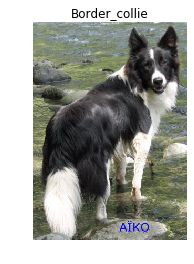

Image Shape: (568, 800, 3)


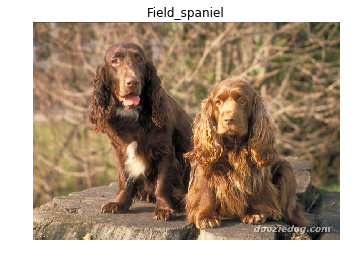

Image Shape: (628, 508, 3)


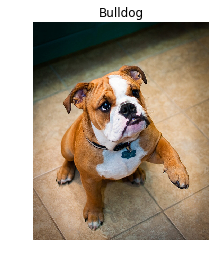

In [12]:
show_random_imgs(3)

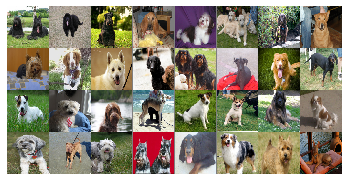

In [0]:
# Get a batch of training data (32 random images)
imgs, classes = next(iter(dataloaders['Train']))

# This PyTorch function makes a grid of images from a batch for us
batch = torchvision.utils.make_grid(imgs)

show_batch(batch)

#### Defining a network in PyTorch

Now its time to finally build our CNN.  In PyTorch, a model is represented by a normal Python class that inherits from the master nn.Module class. Inheriting from this master class grants your model all the methods and attributes needed to train and work with your model. There are, however, 2 things you need to write yourself:
 -  **__init__(self)**: Here is where you define the layers and overall architecture of your model
 -  **forward(self, x)**: This method takes an input, x, computes a forward pass through the network and outputs predictions. Writing it essentially involves connecting your layers and setting up the flow of the input through your layers.
 
 

Below are the signatures of the PyTorch functions that create each of the layers we discussed. Try to use them to build your first CNN! I provided some comments that hopefully guide you in terms of what should happen at each step.

-  nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
-  nn.ReLU(x)
-  nn.MaxPool2d(kernel_size, stride, padding)
-  nn.BatchNorm2d(num_features) - num_features is the number of channels it receives
-  nn.Dropout(p) - p is probability of an element to be zeroed
-  nn.Linear(in_features, out_features) – fully connected layer (matrix multiplications used in the classification portion of a network)

In [0]:
def get_padding(input_dim, output_dim, kernel_size, stride):
  # Calculates padding necessary to create a certain output size,
  # given a input size, kernel size and stride
  
  padding = (((output_dim - 1) * stride) - input_dim + kernel_size) // 2
  
  if padding < 0:
    return 0
  else:
    return padding

In [0]:
# Make sure you calculate the padding amount needed to maintain the spatial size of the input
# after each Conv layer

class CNN(nn.Module):
  
    def __init__(self):
        super(CNN, self).__init__()
        
        # nn.Sequential() is simply a container that groups layers into one object
        # Pass layers into it separated by commas
        self.block1 = nn.Sequential(
            
            # The first convolutional layer. Think about how many channels the input starts off with
            # Let's have this first layer extract 32 features
            nn.Conv2d(3, 32, 3, 1, 1),
            
            # Don't forget to apply a non-linearity
            nn.ReLU())
        
        self.block2 =  nn.Sequential(
            
            # The second convolutional layer. How many channels does it receive, given the number of features extracted by the first layer?
            # Now have this layer extract 64 features
            nn.Conv2d(32, 64, 3, 1, 1),
            
            # Non linearity 
            nn.ReLU(),
            
            # Lets introduce a Batch Normalization layer
            nn.BatchNorm2d(64),
            
            # Downsample the input with Max Pooling
            nn.MaxPool2d(2, 2, 0))
        
        # Mimic the second block here, except have this block extract 128 features
        self.block3 =  nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2, 0))
        
        # Applying a global pooling layer
        # Turns the 128 channel rank 4 tensor into a rank 2 tensor of size 32 x 128 (32 128 length arrays, one for each of the inputs in a batch)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(128, 512)
        
        # Introduce dropout to reduce overfitting
        self.drop_out = nn.Dropout(0.5)
        
        # Final fully connected layer creates the prediction array
        self.fc2 = nn.Linear(512, len(dog_breeds))
    
    # Feeding the input through each of the layers we defined 
    def forward(self, x):
        
        # Input size changes from (32 x 3 x 224 x 224) to (32 x 32 x 224 x 224)
        x = self.block1(x)
        
        # Size changes from (32 x 32 x 224 x 224) to (32 x 64 x 112 x 112) after max pooling
        x = self.block2(x)
        
        # Size changes from (32 x 64 x 112 x 112) to (32 x 128 x 56 x 56) after max pooling
        x = self.block3(x)
        
        # Reshapes the input from (32 x 128 x 56 x 56) to (32 x 128)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layer, size changes from (32 x 128) to (32 x 512)
        x = self.fc1(x)
        x = self.drop_out(x)
        
        # Size change from (32 x 512) to (32 x 133) to create prediction arrays for each of the images in the batch
        x = self.fc2(x)
        
        return x

Now we create an instance of this CNN() class and define the loss function and optimizer we'll use to train our model. In our case we'll use CrossEntropyLoss. You'll notice we never added a Softmax activation after our last layer. That's because PyTorch's CrossEntropyLoss applies a softmax before calculating log loss, a common loss function used in single label classification problems.

For the optimizer we'll use Adam, an easy to apply but powerful optimizer which is an extension of the popular Stochastic Gradient Descent method. We need to pass it all of the parameters it'll train, which PyTorch makes easy with model.parameters(), and also the learning rate we'll use.

In [0]:
try:
    model
except NameError:
    print("First time creating the model")
else:
    print('Overwriting the model')
    del model
    
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
epochs = 20
model.to(device)
print(model)

First time creating the model
CNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (drop_out): Dropout(p=0.5)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
)


## Training a model in PyTorch 

At this point we're finally ready to train our model! In PyTorch we have to write our own training loops before getting to actually train the model. This can seem daunting at first, so let's break up each stage of the training process. 

The bulk of the function is handled by a nested for loop, the outer looping through each epoch and the inner looping through all of the batches of images in our dataset. Each epoch has a training and validation phase, where batches are served from their respective loaders. Both phases begin by feeding a batch of inputs into the model, which implicity calls the forward() function on the input. Then we calculate the loss of the outputs against the true labels of the batch. 

If we're in training mode, here is where we perform back-propagation and a training step. To do this, we first zero the gradients, then perform backpropagation by calling .backward() on the loss variable. Finally, we call optimizer.step() to adjust the weights of the model in accordance with the calculated gradients.

The remaining portion of one epoch is the same for both training and validation, and simply involves calculating and tracking the accuracy achieved in both phases. A nifty addition to this training loop is that it tracks the highest validation accuracy and only saves weights which beat that accuracy, ensuring that the best performing weights are returned from the function.

In [0]:
def train(model, criterion, optimizer, num_epochs, dataloaders, device):
    start = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    train_loss = 0.0
    train_acc = 0.0
    
    print('| Epoch\t | Train Loss\t| Train Acc\t| Valid Loss\t| Valid Acc\t| Epoch Time |')
    print('-' * 86)
    
    # Iterate through epochs
    for epoch in range(num_epochs):
        epoch_start =  time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                # Set model to training mode
                model.train()
            else:
                # Eval mode turns off dropoff and batch norm layers
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
              
                # ensures we're doing this calculation on our GPU if possible
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                time_elapsed = time.time() - epoch_start
                
                if phase == 'Train':
                    print('| {}\t | Batch: {}/{} Time Elapsed: {:.0f}m {:.0f}s \t\t\t\t\t     |'
                          .format(epoch + 1, i + 1, len(dataloaders['Train']), 
                                  time_elapsed // 60, time_elapsed % 60), end = '\r')
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Calculate gradients only if we're in the training phase
                with torch.set_grad_enabled(phase == 'Train'):
                  
                    # This calls the forward() function on a batch of inputs
                    outputs = model(inputs)
                    
                    # Gets the predictions of the inputs (highest value in the array)
                    _, preds = torch.max(outputs, 1)
                    
                    # Calculate the loss of the batch
                    loss = criterion(outputs, labels)

                    # Adjust weights through backpropagation if we're in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # Document statistics for the batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Calculate epoch statistics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_time = time.time() - epoch_start
           
            # Print statistics after the validation phase
            if phase == 'Train':
                train_loss = epoch_loss
                train_acc = epoch_acc
            else:
                print("| {}\t | {:.4f}\t| {:.4f}\t| {:.4f}\t| {:.4f}\t| {:.0f}m {:.0f}s     |"
                      .format(epoch + 1, train_loss, train_acc, epoch_loss, epoch_acc, epoch_time // 60, epoch_time % 60))

            # Copy and save the model's weights if it has the best accuracy thus far
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    total_time = time.time() - start
    
    print('-' * 86)
    print('Training complete in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
    print('Best validation accuracy: {:.4f}'.format(best_acc))

    # load best model weights and return them
    model.load_state_dict(best_model_wts)
    return model

#### Testing a model

Creating a function that generates and prints predictions on a given number of images from our test set

In [0]:
def test_model(model, num_images):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(num_images, (10,10))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Actual: {} \n Prediction: {}'.format(dog_breeds[labels[j]], dog_breeds[preds[j]]))
                
                image = images.cpu().data[j].numpy().transpose((1, 2, 0))
                
                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                image = std * image + mean
                image = np.clip(image, 0, 1)
                
                plt.imshow(image)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

After defining these functions, training and testing our model is straightforward from here on out. Simply call the train() function with the required parameters and let your GPU go to work!

In [0]:
model = train(model, criterion, optimizer, epochs, dataloaders, device)

| Epoch	 | Train Loss	| Train Acc	| Valid Loss	| Valid Acc	| Epoch Time |
--------------------------------------------------------------------------------------
| 1	 | 4.8718	| 0.0141	| 4.8323	| 0.0156	| 1m 21s     |
| 2	 | 4.7896	| 0.0278	| 4.7680	| 0.0263	| 1m 18s     |
| 3	 | 4.7127	| 0.0304	| 4.7040	| 0.0335	| 1m 18s     |
| 4	 | 4.6502	| 0.0352	| 4.6679	| 0.0323	| 1m 17s     |
| 5	 | 4.5849	| 0.0376	| 4.6164	| 0.0467	| 1m 17s     |
| 6	 | 4.5380	| 0.0386	| 4.5966	| 0.0323	| 1m 17s     |
| 7	 | 4.4948	| 0.0424	| 4.5505	| 0.0419	| 1m 18s     |
| 8	 | 4.4447	| 0.0472	| 4.5054	| 0.0443	| 1m 18s     |
| 9	 | 4.3950	| 0.0552	| 4.4551	| 0.0503	| 1m 18s     |
| 10	 | 4.3452	| 0.0633	| 4.4970	| 0.0455	| 1m 18s     |
| 11	 | 4.3018	| 0.0639	| 4.4128	| 0.0539	| 1m 18s     |
| 12	 | 4.2556	| 0.0707	| 4.4119	| 0.0599	| 1m 17s     |
| 13	 | 4.2236	| 0.0725	| 4.3542	| 0.0659	| 1m 17s     |
| 14	 | 4.1832	| 0.0726	| 4.3093	| 0.0683	| 1m 18s     |
| 15	 | 4.1400	| 0.0765	| 4.2722	| 0.0719	| 1m 17s

Ouch! Our model doesn't seem to be performing very well at all. After 20 epochs of training we're barely able to achieve a 10% accuracy on our validation set... Hang in there, in a bit I'll go into some methods we can use to achieve a much better accuracy.

In the meantime, let's quickly take a look at how we can save our PyTorch models. Then we'll test and visualize our model. 

## Saving a model in PyTorch 

There are many ways to save a PyTorch model, however the most robust method is described below. This allows you to load up a model for both testing and further training.

The most important part to understand from the code below is what the model and optimizer **state_dict's** are. The model state_dict is essentially a dictionary which contains all of the learned weights and biases in the model, while the optimizer's contains information about the optimizer’s state hyperparameters used.

Other than the state_dicts, we also save the class used to build the model architecture, as well as the optimizer and loss function. Putting all of this together allows us to save, move around, and later restore our model to it's exact state after training.. A **.tar** file extension is commonly used to bundle all of this together.

In [0]:
torch.save({
            'model' : CNN(),
            'epoch' : epochs,
            'model_state_dict': model.state_dict(),
            'optimizer' : optimizer,
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion' : criterion,
            'device' : device
            }, 'base_model.tar')

/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Creating a function which unpacks the .tar file we saved earlier and loads up the model's saved weights and optimizer state.

In [0]:
def load_checkpoint(filepath):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(filepath, map_location=device)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = checkpoint['optimizer']
    optimizer = optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    criterion = checkpoint['criterion']
    epoch = checkpoint['epoch']
    model.to(device)

    return model, optimizer, criterion, epoch

Loading our model up...

In [0]:
model, optimizer, criterion, epoch = load_checkpoint(root + 'base_model.tar')

Let's test our model on a couple of dogs!

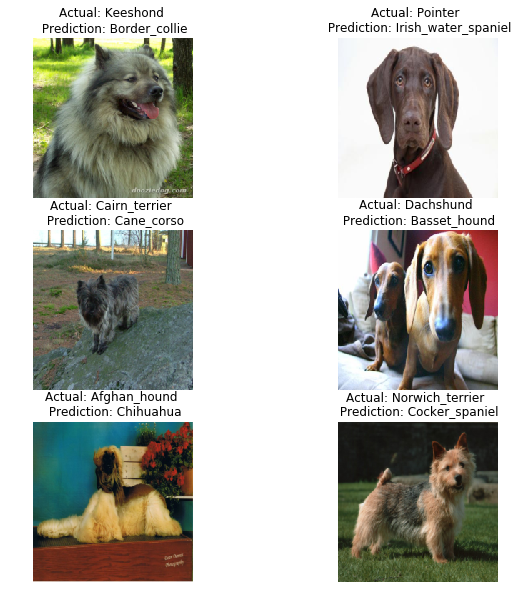

In [0]:
test_model(model, 6)

As expected, our model is predicting the wrong breed for the majority of test images. Why is this?

In short, building and training a CNN from scratch is possible, however most problems require significantly more complex models, trained on huge amounts of data. Of course, the computational power and amount of data needed to train these networks accurately are not always available. This is why the idea of **Transfer Learning** has become so popular. It allows everyday people, like me and you, to build accurate and powerful models with limited resources.

## Transfer Learning  

In transfer learning, we take the architecture and weights of a pre-trained model 
(one that has been trained on millions of images belonging to 1000’s of classes, on several high power GPU’s for several days) 
and use the already learnt features to solve our own novel problem

PyTorch actually comes with a number of models which have already been trained on the Imagenet dataset we discussed earlier, making it quite simple for us to apply this method of transfer learning. We'll be using a powerful but lighweight model called ResNet18, we import it like so:
-  from torchvision.models import resnet18

The next block of code might look a bit foreign. What we're doing is actually looping through all of the model's pretrained weights and **freezing** them. This means that during training these weights will not be updating at all. We then take the entire ResNet model and put it into one block of our model, named feature_extraction. It's important to understand that when you load a pretrained model you are only receiving the feature extraction block, or the convolutional layers. It's up to us to define a classification block which can take all of the features the ResNet model extracted and use them to actually classify an image.

In [0]:
class PreTrained_Resnet(nn.Module):
    def __init__(self):
        super(PreTrained_Resnet, self).__init__()
        
        # Loading up a pretrained ResNet18 model
        resnet = resnet18(pretrained = True)
        
        # Freeze the entire pretrained network
        for layer in resnet.parameters():
            layer.requires_grad = False
            
        self.feature_extraction = resnet
        
        # Write the classifier block for this network      
            # Tip: ResNet18's feature extraction portion ends up with 1000 feature maps, and then implements a Global Average Pooling layer
            # So what would the size and dimension of the output tensor be?
            # Think about how can we take that output tensor and transform it into an array of dog breed predictions...
        self.classifier = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(dog_breeds)),
            nn.LogSoftmax(1))
    
    # Write the forward method for this network (it's quite simple since we've defined the network in blocks already)
    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.classifier(x)
        return x

In [0]:
# Instantiate a pretrained network using the class we've just defined
# Then define the loss function and optimizer to use for training (let's use Adam again, with the same parameters as before)

pretrained = PreTrained_Resnet()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(pretrained.classifier.parameters(), lr = 0.0001)
epochs2 = 20
pretrained.to(device)
print(pretrained)

PreTrained_Resnet(
  (feature_extraction): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [0]:
pretrained = train(pretrained, criterion2, optimizer2, epochs2, dataloaders, device)

| Epoch	 | Train Loss	| Train Acc	| Valid Loss	| Valid Acc	| Epoch Time |
--------------------------------------------------------------------------------------
| 1	 | 1.6224	| 0.5662	| 1.0972	| 0.7114	| 2m 36s     |
| 2	 | 1.2853	| 0.6341	| 0.9292	| 0.7353	| 2m 36s     |
| 3	 | 1.0934	| 0.6793	| 0.8318	| 0.7593	| 2m 36s     |
| 4	 | 0.9803	| 0.7085	| 0.7717	| 0.7808	| 2m 36s     |
| 5	 | 0.9004	| 0.7314	| 0.7314	| 0.7820	| 2m 37s     |
| 6	 | 0.8064	| 0.7612	| 0.6959	| 0.8060	| 2m 37s     |
| 7	 | 0.7250	| 0.7844	| 0.6893	| 0.8084	| 2m 36s     |
| 8	 | 0.6708	| 0.7918	| 0.6735	| 0.7940	| 2m 36s     |
| 9	 | 0.6583	| 0.7945	| 0.6502	| 0.8072	| 2m 36s     |
| 10	 | 0.6105	| 0.8139	| 0.6510	| 0.8024	| 2m 36s     |
| 11	 | 0.5881	| 0.8196	| 0.6402	| 0.8132	| 2m 37s     |
| 12	 | 0.5464	| 0.8305	| 0.6355	| 0.7964	| 2m 36s     |
| 13	 | 0.5263	| 0.8394	| 0.6205	| 0.8084	| 2m 36s     |
| 14	 | 0.5085	| 0.8436	| 0.6160	| 0.8048	| 2m 37s     |
| 15	 | 0.4770	| 0.8487	| 0.6205	| 0.8108	| 2m 36s

This quick example shows the power of transfer learning. With relatively few lines of code we're able to achieve over an 80% accuracy on this dog breeds dataset! And there are still a number of things we could have done, or do from here, to achieve even better performance. Things such as:
 -  Unfreezing the last few layers of the ResNet base and training some more on our specific dataset (more on this in a bit)
 -  Optimizing the hyperparameters of our model (learning rate, etc.)
 -  Utilizing an even more powerful pretrained architecture (Resnet34, 50, etc.)
 -  Creating a custom learning rate schedule

We'll save the model, then load it back up using the function we defined earlier.

In [0]:
torch.save({
            'model' : PreTrained_Resnet(),
            'epoch' : epochs2,
            'model_state_dict': pretrained.state_dict(),
            'optimizer' : optimizer2,
            'optimizer_state_dict': optimizer2.state_dict(),
            'criterion' : criterion2,
            'device' : device
            }, 'pretrained.tar')

/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PreTrained_Resnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
pretrained, optimizer2, criterion2, epoch2 = load_checkpoint(root + 'pretrained.tar')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Finally we can test our new pretrained ResNet model! As you can see, with transfer learning we can create quite accurate models relatively easily.

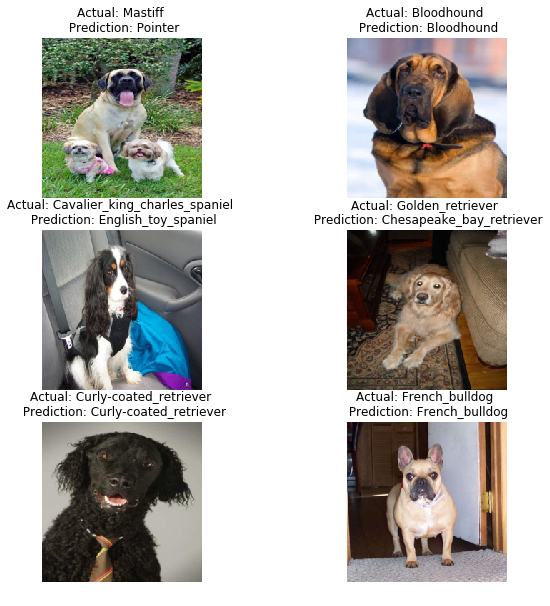

In [0]:
test_model(pretrained, 6)

#### More on Transfer Learning

In this example, we simply took a pretrained model and added our classification (fully connected layers) block right on top. We froze the entire pretrained network and only updated the weights of our fully connected layers. This means we didn't change the pretrained weights at all, and only used what it had 'learned' from the dataset which it was trained on. 

However, I mentioned earlier that we could achieve even better performance if we unfroze the last few layers of the pretrained model and trained them some on our specific dataset. But why?

<img src = "https://drive.google.com/uc?id=10ce5aTD47lIsO1eYfZmbs_sbDDUfaZiT"> <img src = "https://drive.google.com/uc?id=1BfHJXrWwl4oVyPZ2_p602nD9HkF4RoSR">

Going back to the layer visualizations we saw earlier, we know the earlier layers of the pretrained network learn to recognize simple lines, patterns, objects, etc. However, as we progress in the network, the layers learn to recognize things more specific to the dataset which it was trained on. In this case, ImageNet, which we described a bit earlier.

If you remember, ImageNet contains images that are *somewhat* similar to our dog breeds dataset, so much of what the model 'learned' also applied to our dataset. Hence why we were able to achieve a pretty good accuracy without adjusting the pretrained model whatsoever. 

Of course, much of what the deeper layers learned from ImageNet did **not** apply to dog images. This is why training the last few layers would be beneficial. It would allow the model to adjust and recognize rich features specific to **only dogs**. Things such as types of dog ears, tails, fur, noses, etc. etc.

## Thank you for coming out tonight! 

## Don't forget to fill out the sign out sheet and see you next week!